In [119]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [120]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [121]:
key = os.environ.get('AZURE_SEARCH_KEY', '69ea3c57000c4f0e9a0a30bde72681ce')
key
def search_images_bing(key, term, max_images: int = 100, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [122]:
key;
results = search_images_bing(key, 'langur')
ims = results.attrgot('content_url')
len(ims)

100

In [123]:
#monkeys_types = 'grizzly','black','teddy'
#path = Path('monkeys')
#monkeys_types

In [124]:
monkeys_types = 'langur','orangutan','chimpanzee'
path = Path('monkeys')
monkeys_types

('langur', 'orangutan', 'chimpanzee')

In [125]:
if not path.exists():
  path.mkdir()
for o in monkeys_types:
        dest = (path/o)
        print(dest)
        dest.mkdir(exist_ok=True)
        #results = search_images_bing(key, f'{o} monkeys'.format(o))
        results = search_images_bing(key, f'{o}'.format(o))
        len(results)
        #download_images(dest, urls=results.attrgot('content_url'))
        download_images(dest, urls=results.attrgot('contentUrl'))

monkeys/langur


monkeys/orangutan


monkeys/chimpanzee


In [126]:
results
fns = get_image_files(path)
fns

(#333) [Path('monkeys/chimpanzee/00000077.jpg'),Path('monkeys/chimpanzee/00000092.jpg'),Path('monkeys/chimpanzee/00000084.jpg'),Path('monkeys/chimpanzee/00000087.jpg'),Path('monkeys/chimpanzee/00000000.jpg'),Path('monkeys/chimpanzee/00000085.jpg'),Path('monkeys/chimpanzee/00000035.jpg'),Path('monkeys/chimpanzee/00000008.jpg'),Path('monkeys/chimpanzee/00000073.jpg'),Path('monkeys/chimpanzee/00000039.jpg')...]

In [127]:
failed = verify_images(fns)
failed

(#10) [Path('monkeys/chimpanzee/00000006.jpg'),Path('monkeys/chimpanzee/00000015.jpg'),Path('monkeys/langur/00000032.jpg'),Path('monkeys/langur/00000016.jpg'),Path('monkeys/langur/00000029.jpg'),Path('monkeys/orangutan/00000085.jpg'),Path('monkeys/orangutan/00000039.jpg'),Path('monkeys/orangutan/00000046.jpg'),Path('monkeys/orangutan/00000054.jpg'),Path('monkeys/orangutan/00000068.jpg')]

In [128]:
failed.map(Path.unlink);

In [129]:
monkeys = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [130]:
dls = monkeys.dataloaders(path)

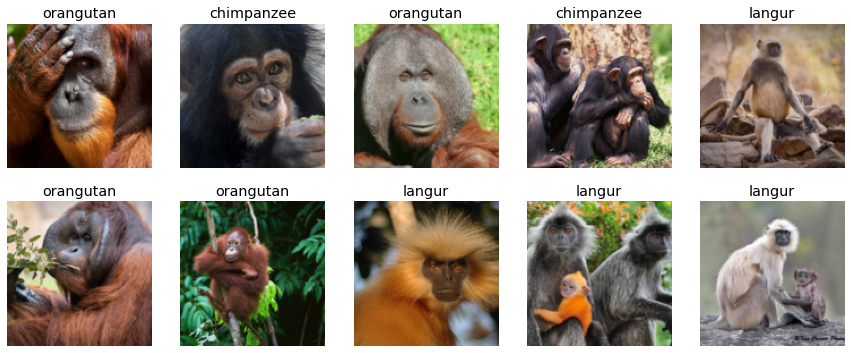

In [131]:
dls.valid.show_batch(max_n=10, nrows=2)

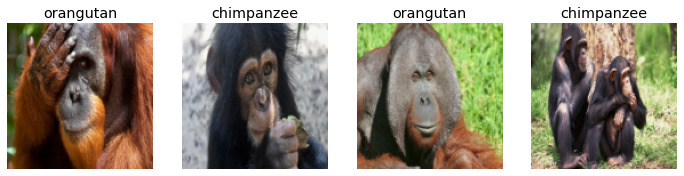

In [132]:
monkeys = monkeys.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = monkeys.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

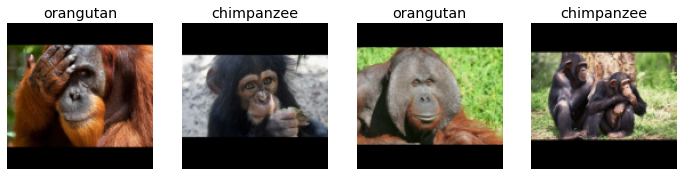

In [133]:
monkeys = monkeys.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = monkeys.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

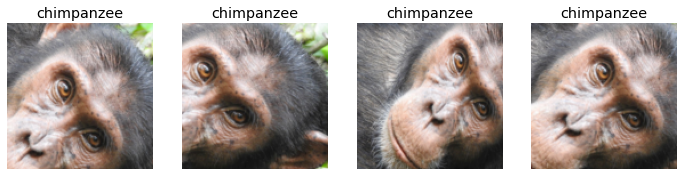

In [134]:
monkeys = monkeys.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = monkeys.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

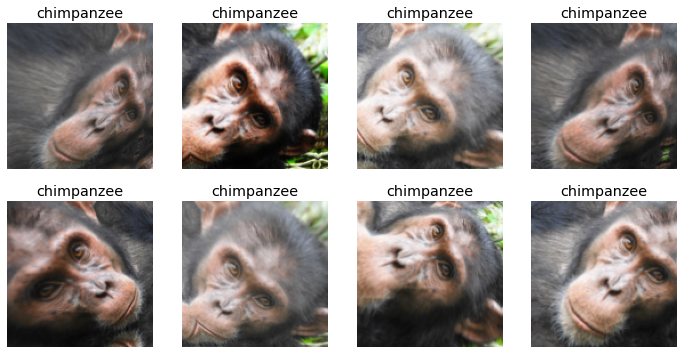

In [135]:
monkeys = monkeys.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = monkeys.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

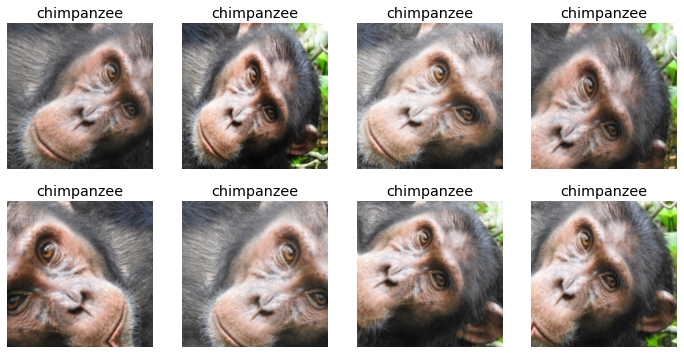

In [136]:
monkeys = monkeys.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = monkeys.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.634692,0.431095,0.156250,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.605305,0.351856,0.125000,01:29


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

#hide_output
btn_upload = widgets.FileUpload()
btn_upload
out_pl = widgets.Output()
out_pl.clear_output()
lbl_pred = widgets.Label()

#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


      


In [ ]:
#btn_upload.observe(on_click, name=['data'])
display(VBox([widgets.Label('Select your monkeys!'),btn_upload, btn_run, out_pl, lbl_pred]))